In [1]:
import torch
import torchvision
from torchvision.transforms import v2
import torchvision.models as models
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader

import os
import math
import random
import numpy as np
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import time
import wandb
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, accuracy_score

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
"""
Author: Omid Nejati
Email: omid_nejaty@alumni.iust.ac.ir

MedViT: A Robust Vision Transformer for Generalized Medical Image Classification.
"""
from functools import partial
import math
import torch
import torch.utils.checkpoint as checkpoint
from einops import rearrange
from timm.models.layers import DropPath, trunc_normal_
from timm.models.registry import register_model
from torch import nn

NORM_EPS = 1e-5

def merge_pre_bn(module, pre_bn_1, pre_bn_2=None):
    """ Merge pre BN to reduce inference runtime.
    """
    weight = module.weight.data
    if module.bias is None:
        zeros = torch.zeros(module.out_channels, device=weight.device).type(weight.type())
        module.bias = nn.Parameter(zeros)
    bias = module.bias.data
    if pre_bn_2 is None:
        assert pre_bn_1.track_running_stats is True, "Unsupport bn_module.track_running_stats is False"
        assert pre_bn_1.affine is True, "Unsupport bn_module.affine is False"

        scale_invstd = pre_bn_1.running_var.add(pre_bn_1.eps).pow(-0.5)
        extra_weight = scale_invstd * pre_bn_1.weight
        extra_bias = pre_bn_1.bias - pre_bn_1.weight * pre_bn_1.running_mean * scale_invstd
    else:
        assert pre_bn_1.track_running_stats is True, "Unsupport bn_module.track_running_stats is False"
        assert pre_bn_1.affine is True, "Unsupport bn_module.affine is False"

        assert pre_bn_2.track_running_stats is True, "Unsupport bn_module.track_running_stats is False"
        assert pre_bn_2.affine is True, "Unsupport bn_module.affine is False"

        scale_invstd_1 = pre_bn_1.running_var.add(pre_bn_1.eps).pow(-0.5)
        scale_invstd_2 = pre_bn_2.running_var.add(pre_bn_2.eps).pow(-0.5)

        extra_weight = scale_invstd_1 * pre_bn_1.weight * scale_invstd_2 * pre_bn_2.weight
        extra_bias = scale_invstd_2 * pre_bn_2.weight *(pre_bn_1.bias - pre_bn_1.weight * pre_bn_1.running_mean * scale_invstd_1 - pre_bn_2.running_mean) + pre_bn_2.bias

    if isinstance(module, nn.Linear):
        extra_bias = weight @ extra_bias
        weight.mul_(extra_weight.view(1, weight.size(1)).expand_as(weight))
    elif isinstance(module, nn.Conv2d):
        assert weight.shape[2] == 1 and weight.shape[3] == 1
        weight = weight.reshape(weight.shape[0], weight.shape[1])
        extra_bias = weight @ extra_bias
        weight.mul_(extra_weight.view(1, weight.size(1)).expand_as(weight))
        weight = weight.reshape(weight.shape[0], weight.shape[1], 1, 1)
    bias.add_(extra_bias)

    module.weight.data = weight
    module.bias.data = bias


class ConvBNReLU(nn.Module):
    def __init__(
            self,
            in_channels,
            out_channels,
            kernel_size,
            stride,
            groups=1):
        super(ConvBNReLU, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride,
                              padding=1, groups=groups, bias=False)
        self.norm = nn.BatchNorm2d(out_channels, eps=NORM_EPS)
        self.act = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.norm(x)
        x = self.act(x)
        return x


def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


class PatchEmbed(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride=1):
        super(PatchEmbed, self).__init__()
        norm_layer = partial(nn.BatchNorm2d, eps=NORM_EPS)
        if stride == 2:
            self.avgpool = nn.AvgPool2d((2, 2), stride=2, ceil_mode=True, count_include_pad=False)
            self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
            self.norm = norm_layer(out_channels)
        elif in_channels != out_channels:
            self.avgpool = nn.Identity()
            self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
            self.norm = norm_layer(out_channels)
        else:
            self.avgpool = nn.Identity()
            self.conv = nn.Identity()
            self.norm = nn.Identity()

    def forward(self, x):
        return self.norm(self.conv(self.avgpool(x)))


class MHCA(nn.Module):
    """
    Multi-Head Convolutional Attention
    """
    def __init__(self, out_channels, head_dim):
        super(MHCA, self).__init__()
        norm_layer = partial(nn.BatchNorm2d, eps=NORM_EPS)
        self.group_conv3x3 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1,
                                       padding=1, groups=out_channels // head_dim, bias=False)
        self.norm = norm_layer(out_channels)
        self.act = nn.ReLU(inplace=True)
        self.projection = nn.Conv2d(out_channels, out_channels, kernel_size=1, bias=False)

    def forward(self, x):
        out = self.group_conv3x3(x)
        out = self.norm(out)
        out = self.act(out)
        out = self.projection(out)
        return out

class h_sigmoid(nn.Module):
    def __init__(self, inplace=True):
        super(h_sigmoid, self).__init__()
        self.relu = nn.ReLU6(inplace=inplace)

    def forward(self, x):
        return self.relu(x + 3) / 6


class h_swish(nn.Module):
    def __init__(self, inplace=True):
        super(h_swish, self).__init__()
        self.sigmoid = h_sigmoid(inplace=inplace)

    def forward(self, x):
        return x * self.sigmoid(x)


class ECALayer(nn.Module):
    def __init__(self, channel, gamma=2, b=1, sigmoid=True):
        super(ECALayer, self).__init__()
        t = int(abs((math.log(channel, 2) + b) / gamma))
        k = t if t % 2 else t + 1

        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv = nn.Conv1d(1, 1, kernel_size=k, padding=k // 2, bias=False)
        if sigmoid:
            self.sigmoid = nn.Sigmoid()
        else:
            self.sigmoid = h_sigmoid()

    def forward(self, x):
        y = self.avg_pool(x)
        y = self.conv(y.squeeze(-1).transpose(-1, -2))
        y = y.transpose(-1, -2).unsqueeze(-1)
        y = self.sigmoid(y)
        return x * y.expand_as(x)


class SELayer(nn.Module):
    def __init__(self, channel, reduction=4):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
                nn.Linear(channel, channel // reduction),
                nn.ReLU(inplace=True),
                nn.Linear(channel // reduction, channel),
                h_sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

class LocalityFeedForward(nn.Module):
    def __init__(self, in_dim, out_dim, stride, expand_ratio=4., act='hs+se', reduction=4,
                 wo_dp_conv=False, dp_first=False):
        """
        :param in_dim: the input dimension
        :param out_dim: the output dimension. The input and output dimension should be the same.
        :param stride: stride of the depth-wise convolution.
        :param expand_ratio: expansion ratio of the hidden dimension.
        :param act: the activation function.
                    relu: ReLU
                    hs: h_swish
                    hs+se: h_swish and SE module
                    hs+eca: h_swish and ECA module
                    hs+ecah: h_swish and ECA module. Compared with eca, h_sigmoid is used.
        :param reduction: reduction rate in SE module.
        :param wo_dp_conv: without depth-wise convolution.
        :param dp_first: place depth-wise convolution as the first layer.
        """
        super(LocalityFeedForward, self).__init__()
        hidden_dim = int(in_dim * expand_ratio)
        kernel_size = 3

        layers = []
        # the first linear layer is replaced by 1x1 convolution.
        layers.extend([
            nn.Conv2d(in_dim, hidden_dim, 1, 1, 0, bias=False),
            nn.BatchNorm2d(hidden_dim),
            h_swish() if act.find('hs') >= 0 else nn.ReLU6(inplace=True)])

        # the depth-wise convolution between the two linear layers
        if not wo_dp_conv:
            dp = [
                nn.Conv2d(hidden_dim, hidden_dim, kernel_size, stride, kernel_size // 2, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                h_swish() if act.find('hs') >= 0 else nn.ReLU6(inplace=True)
            ]
            if dp_first:
                layers = dp + layers
            else:
                layers.extend(dp)

        if act.find('+') >= 0:
            attn = act.split('+')[1]
            if attn == 'se':
                layers.append(SELayer(hidden_dim, reduction=reduction))
            elif attn.find('eca') >= 0:
                layers.append(ECALayer(hidden_dim, sigmoid=attn == 'eca'))
            else:
                raise NotImplementedError('Activation type {} is not implemented'.format(act))

        # the second linear layer is replaced by 1x1 convolution.
        layers.extend([
            nn.Conv2d(hidden_dim, out_dim, 1, 1, 0, bias=False),
            nn.BatchNorm2d(out_dim)
        ])
        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        x = x + self.conv(x)
        return x


class Mlp(nn.Module):
    def __init__(self, in_features, out_features=None, mlp_ratio=None, drop=0., bias=True):
        super().__init__()
        out_features = out_features or in_features
        hidden_dim = _make_divisible(in_features * mlp_ratio, 32)
        self.conv1 = nn.Conv2d(in_features, hidden_dim, kernel_size=1, bias=bias)
        self.act = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(hidden_dim, out_features, kernel_size=1, bias=bias)
        self.drop = nn.Dropout(drop)

    def merge_bn(self, pre_norm):
        merge_pre_bn(self.conv1, pre_norm)

    def forward(self, x):
        x = self.conv1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.conv2(x)
        x = self.drop(x)
        return x


class ECB(nn.Module):
    """
    Efficient Convolution Block
    """
    def __init__(self, in_channels, out_channels, stride=1, path_dropout=0,
                 drop=0, head_dim=32, mlp_ratio=3):
        super(ECB, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        norm_layer = partial(nn.BatchNorm2d, eps=NORM_EPS)
        assert out_channels % head_dim == 0

        self.patch_embed = PatchEmbed(in_channels, out_channels, stride)
        self.mhca = MHCA(out_channels, head_dim)
        self.attention_path_dropout = DropPath(path_dropout)

        self.conv = LocalityFeedForward(out_channels, out_channels, 1, mlp_ratio, reduction=out_channels)

        self.norm = norm_layer(out_channels)
        #self.mlp = Mlp(out_channels, mlp_ratio=mlp_ratio, drop=drop, bias=True)
        #self.mlp_path_dropout = DropPath(path_dropout)
        self.is_bn_merged = False

    def merge_bn(self):
        if not self.is_bn_merged:
            self.mlp.merge_bn(self.norm)
            self.is_bn_merged = True

    def forward(self, x):
        x = self.patch_embed(x)
        x = x + self.attention_path_dropout(self.mhca(x))
        if not torch.onnx.is_in_onnx_export() and not self.is_bn_merged:
            out = self.norm(x)
        else:
            out = x
        #x = x + self.mlp_path_dropout(self.mlp(out))
        x = x + self.conv(out) # (B, dim, 14, 14)
        return x


class E_MHSA(nn.Module):
    """
    Efficient Multi-Head Self Attention
    """
    def __init__(self, dim, out_dim=None, head_dim=32, qkv_bias=True, qk_scale=None,
                 attn_drop=0, proj_drop=0., sr_ratio=1):
        super().__init__()
        self.dim = dim
        self.out_dim = out_dim if out_dim is not None else dim
        self.num_heads = self.dim // head_dim
        self.scale = qk_scale or head_dim ** -0.5
        self.q = nn.Linear(dim, self.dim, bias=qkv_bias)
        self.k = nn.Linear(dim, self.dim, bias=qkv_bias)
        self.v = nn.Linear(dim, self.dim, bias=qkv_bias)
        self.proj = nn.Linear(self.dim, self.out_dim)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj_drop = nn.Dropout(proj_drop)

        self.sr_ratio = sr_ratio
        self.N_ratio = sr_ratio ** 2
        if sr_ratio > 1:
            self.sr = nn.AvgPool1d(kernel_size=self.N_ratio, stride=self.N_ratio)
            self.norm = nn.BatchNorm1d(dim, eps=NORM_EPS)
        self.is_bn_merged = False

    def merge_bn(self, pre_bn):
        merge_pre_bn(self.q, pre_bn)
        if self.sr_ratio > 1:
            merge_pre_bn(self.k, pre_bn, self.norm)
            merge_pre_bn(self.v, pre_bn, self.norm)
        else:
            merge_pre_bn(self.k, pre_bn)
            merge_pre_bn(self.v, pre_bn)
        self.is_bn_merged = True

    def forward(self, x):
        B, N, C = x.shape
        q = self.q(x)
        q = q.reshape(B, N, self.num_heads, int(C // self.num_heads)).permute(0, 2, 1, 3)

        if self.sr_ratio > 1:
            x_ = x.transpose(1, 2)
            x_ = self.sr(x_)
            if not torch.onnx.is_in_onnx_export() and not self.is_bn_merged:
                x_ = self.norm(x_)
            x_ = x_.transpose(1, 2)
            k = self.k(x_)
            k = k.reshape(B, -1, self.num_heads, int(C // self.num_heads)).permute(0, 2, 3, 1)
            v = self.v(x_)
            v = v.reshape(B, -1, self.num_heads, int(C // self.num_heads)).permute(0, 2, 1, 3)
        else:
            k = self.k(x)
            k = k.reshape(B, -1, self.num_heads, int(C // self.num_heads)).permute(0, 2, 3, 1)
            v = self.v(x)
            v = v.reshape(B, -1, self.num_heads, int(C // self.num_heads)).permute(0, 2, 1, 3)
        attn = (q @ k) * self.scale

        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class LTB(nn.Module):
    """
    Local Transformer Block
    """
    def __init__(
            self, in_channels, out_channels, path_dropout, stride=1, sr_ratio=1,
            mlp_ratio=2, head_dim=32, mix_block_ratio=0.75, attn_drop=0, drop=0,
    ):
        super(LTB, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.mix_block_ratio = mix_block_ratio
        norm_func = partial(nn.BatchNorm2d, eps=NORM_EPS)

        self.mhsa_out_channels = _make_divisible(int(out_channels * mix_block_ratio), 32)
        self.mhca_out_channels = out_channels - self.mhsa_out_channels

        self.patch_embed = PatchEmbed(in_channels, self.mhsa_out_channels, stride)
        self.norm1 = norm_func(self.mhsa_out_channels)
        self.e_mhsa = E_MHSA(self.mhsa_out_channels, head_dim=head_dim, sr_ratio=sr_ratio,
                             attn_drop=attn_drop, proj_drop=drop)
        self.mhsa_path_dropout = DropPath(path_dropout * mix_block_ratio)

        self.projection = PatchEmbed(self.mhsa_out_channels, self.mhca_out_channels, stride=1)
        self.mhca = MHCA(self.mhca_out_channels, head_dim=head_dim)
        self.mhca_path_dropout = DropPath(path_dropout * (1 - mix_block_ratio))

        self.norm2 = norm_func(out_channels)
        self.conv = LocalityFeedForward(out_channels, out_channels, 1, mlp_ratio, reduction=out_channels)

        #self.mlp = Mlp(out_channels, mlp_ratio=mlp_ratio, drop=drop)
        #self.mlp_path_dropout = DropPath(path_dropout)

        self.is_bn_merged = False

    def merge_bn(self):
        if not self.is_bn_merged:
            self.e_mhsa.merge_bn(self.norm1)
            self.mlp.merge_bn(self.norm2)
            self.is_bn_merged = True

    def forward(self, x):
        x = self.patch_embed(x)
        B, C, H, W = x.shape
        if not torch.onnx.is_in_onnx_export() and not self.is_bn_merged:
            out = self.norm1(x)
        else:
            out = x
        out = rearrange(out, "b c h w -> b (h w) c")  # b n c
        out = self.mhsa_path_dropout(self.e_mhsa(out))
        x = x + rearrange(out, "b (h w) c -> b c h w", h=H)

        out = self.projection(x)
        out = out + self.mhca_path_dropout(self.mhca(out))
        x = torch.cat([x, out], dim=1)

        if not torch.onnx.is_in_onnx_export() and not self.is_bn_merged:
            out = self.norm2(x)
        else:
            out = x
        x = x + self.conv(out)
        #x = x + self.mlp_path_dropout(self.mlp(out))
        return x


class MedViT(nn.Module):
    def __init__(self, stem_chs, depths, path_dropout, attn_drop=0, drop=0, num_classes=1000,
                 strides=[1, 2, 2, 2], sr_ratios=[8, 4, 2, 1], head_dim=32, mix_block_ratio=0.75,
                 use_checkpoint=False):
        super(MedViT, self).__init__()
        self.use_checkpoint = use_checkpoint

        self.stage_out_channels = [[96] * (depths[0]),
                                   [192] * (depths[1] - 1) + [256],
                                   [384, 384, 384, 384, 512] * (depths[2] // 5),
                                   [768] * (depths[3] - 1) + [1024]]

        # Next Hybrid Strategy
        self.stage_block_types = [[ECB] * depths[0],
                                  [ECB] * (depths[1] - 1) + [LTB],
                                  [ECB, ECB, ECB, ECB, LTB] * (depths[2] // 5),
                                  [ECB] * (depths[3] - 1) + [LTB]]

        self.stem = nn.Sequential(
            ConvBNReLU(3, stem_chs[0], kernel_size=3, stride=2),
            ConvBNReLU(stem_chs[0], stem_chs[1], kernel_size=3, stride=1),
            ConvBNReLU(stem_chs[1], stem_chs[2], kernel_size=3, stride=1),
            ConvBNReLU(stem_chs[2], stem_chs[2], kernel_size=3, stride=2),
        )
        input_channel = stem_chs[-1]
        features = []
        idx = 0
        dpr = [x.item() for x in torch.linspace(0, path_dropout, sum(depths))]  # stochastic depth decay rule
        for stage_id in range(len(depths)):
            numrepeat = depths[stage_id]
            output_channels = self.stage_out_channels[stage_id]
            block_types = self.stage_block_types[stage_id]
            for block_id in range(numrepeat):
                if strides[stage_id] == 2 and block_id == 0:
                    stride = 2
                else:
                    stride = 1
                output_channel = output_channels[block_id]
                block_type = block_types[block_id]
                if block_type is ECB:
                    layer = ECB(input_channel, output_channel, stride=stride, path_dropout=dpr[idx + block_id],
                                drop=drop, head_dim=head_dim)
                    features.append(layer)
                elif block_type is LTB:
                    layer = LTB(input_channel, output_channel, path_dropout=dpr[idx + block_id], stride=stride,
                                sr_ratio=sr_ratios[stage_id], head_dim=head_dim, mix_block_ratio=mix_block_ratio,
                                attn_drop=attn_drop, drop=drop)
                    features.append(layer)
                input_channel = output_channel
            idx += numrepeat
        self.features = nn.Sequential(*features)

        self.norm = nn.BatchNorm2d(output_channel, eps=NORM_EPS)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.proj_head = nn.Sequential(
            nn.Linear(output_channel, num_classes),
        )

        self.stage_out_idx = [sum(depths[:idx + 1]) - 1 for idx in range(len(depths))]
        print('initialize_weights...')
        self._initialize_weights()

    def merge_bn(self):
        self.eval()
        for idx, module in self.named_modules():
            if isinstance(module, ECB) or isinstance(module, LTB):
                module.merge_bn()

    def _initialize_weights(self):
        for n, m in self.named_modules():
            if isinstance(m, (nn.BatchNorm2d, nn.GroupNorm, nn.LayerNorm, nn.BatchNorm1d)):
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                trunc_normal_(m.weight, std=.02)
                if hasattr(m, 'bias') and m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Conv2d):
                trunc_normal_(m.weight, std=.02)
                if hasattr(m, 'bias') and m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.stem(x)
        for idx, layer in enumerate(self.features):
            if self.use_checkpoint:
                x = checkpoint.checkpoint(layer, x)
            else:
                x = layer(x)
        x = self.norm(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.proj_head(x)
        return x

def MedViT_small(pretrained=False, pretrained_cfg=None, **kwargs):
    model = MedViT(stem_chs=[64, 32, 64], depths=[3, 4, 10, 3], path_dropout=0.1, **kwargs)
    return model
    
def MedViT_base(pretrained=False, pretrained_cfg=None, **kwargs):
    model = MedViT(stem_chs=[64, 32, 64], depths=[3, 4, 20, 3], path_dropout=0.2, **kwargs)
    return model

def MedViT_large(pretrained=False, pretrained_cfg=None, **kwargs):
    model = MedViT(stem_chs=[64, 32, 64], depths=[3, 4, 30, 3], path_dropout=0.2, **kwargs)
    return model

/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.12/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


In [4]:
from torch.utils.data import Dataset

class KidneyDataset(Dataset):
    def __init__(self, csv_dir, root_dir, transform=None):
        self.csv = pd.read_csv(csv_dir)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.csv)

    def __getitem__(self, idx):
        row = self.csv.iloc[idx]
        img_path = self.root_dir / row['diag'] / (row['image_id'] + '.jpg')
        img = Image.open(img_path).convert('RGB')
        label = row['target']

        if self.transform is not None:
            img = self.transform(img)

        return img, label

In [5]:
# Define color codes for terminal
class Colors:
    RESET = '\033[0m'
    GREEN = '\033[92m'
    RED = '\033[91m'
    YELLOW = '\033[93m'
    CYAN = '\033[96m'

def display_progress_bar(batch_idx, num_batches, loss, accuracy):
    """
    Function to display a colored progress bar.
    Args:
        batch_idx: Current batch index
        num_batches: Total number of batches
        loss: Current loss value
        accuracy: Current accuracy value
    """
    progress = (batch_idx + 1) / num_batches
    bar_length = 40  # Length of the progress bar (number of '==' chars)
    filled_length = int(bar_length * progress)
    bar = f"{Colors.GREEN}{'=' * filled_length}{Colors.RED}{'-' * (bar_length - filled_length)}{Colors.RESET}"

    print(f'\r[{bar}] {batch_idx + 1}/{num_batches} | {Colors.YELLOW}Loss:{Colors.RESET} {loss:.3f} | {Colors.YELLOW}Accuracy:{Colors.RESET} {accuracy:.2f}%', end='', flush=True)

In [6]:
import matplotlib.pyplot as plt

def plot_result(history, title="Training Progress"):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train', color='tomato')
    plt.plot(epochs, history['val_loss'], label='Validation', color='steelblue')
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(frameon=False)
    plt.grid(True, linestyle="--", alpha=0.3)

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train', color='mediumseagreen')
    plt.plot(epochs, history['val_acc'], label='Validation', color='black')
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(frameon=False)
    plt.grid(True, linestyle="--", alpha=0.3)

    plt.suptitle(title, fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [7]:
import copy


class EarlyStopping:
    def __init__(self, patience=5, delta=1e-3):
        self.patience = patience
        self.delta = delta
        self.best_loss = float("inf")
        self.counter = 0
        self.best_model_state = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_loss - val_loss > self.delta:
            self.best_loss = val_loss
            self.best_model_state = self.best_model_state = copy.deepcopy(
                model.state_dict()
            )
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def load_best_model(self, model):
        if self.best_model_state is not None:
            model.load_state_dict(self.best_model_state)


In [8]:
import os
from typing import Optional, Any
from datetime import datetime
import time

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


class Trainer:
    def __init__(
        self,
        model: nn.Module,
        device: torch.device,
        optimizer: optim.Optimizer,
        criterion: nn.Module,
        scheduler: Optional[Any] = None,
    ):
        self.model = model.to(device)
        self.device = device
        self.optimizer = optimizer
        self.criterion = criterion
        self.scheduler = scheduler
        self.history = {
            "train_loss": [],
            "train_acc": [],
            "val_loss": [],
            "val_acc": [],
        }

    def _run_epoch(self, loader, training=True, show_progress=True):
        self.model.train() if training else self.model.eval()

        running_loss = 0.0
        correct = 0
        total = 0
        all_preds, all_targets = [], []
        num_batches = len(loader)

        with torch.set_grad_enabled(training):
            for batch_idx, (inputs, targets) in enumerate(loader):
                inputs = inputs.to(self.device, non_blocking=True)
                targets = targets.to(self.device, non_blocking=True)

                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)

                if training:
                    loss.backward()
                    self.optimizer.step()
                    self.optimizer.zero_grad()

                running_loss += loss.item()
                _, preds = outputs.max(1)
                total += targets.size(0)
                correct += preds.eq(targets).sum().item()

                all_preds.extend(preds.cpu().tolist())
                all_targets.extend(targets.cpu().tolist())

                if show_progress:
                    current_loss = running_loss / (batch_idx + 1)
                    current_acc = 100.0 * correct / total

                    display_progress_bar(
                        batch_idx=batch_idx,
                        num_batches=num_batches,
                        loss=current_loss,
                        accuracy=current_acc,
                    )

        if show_progress:
            print()

        epoch_loss = running_loss / num_batches
        epoch_acc = 100.0 * accuracy_score(all_targets, all_preds)

        return epoch_loss, epoch_acc, all_preds, all_targets

    def fit(
        self,
        trainloader,
        valloader,
        epochs=10,
        patience=20,
        delta=1e-4,
        model_name="model",
        topk=5,
    ):
        best_vloss = float("inf")
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        start_time = time.time()
        early_stopping = EarlyStopping(patience=patience, delta=delta)
        topk_models = []

        for epoch in range(epochs):
            model_path = f"{model_name}_e{epoch}_{timestamp}.pt"

            print(f"\nEpoch {epoch + 1}/{epochs} - Training")
            t_loss, t_acc, _, _ = self._run_epoch(
                trainloader, training=True, show_progress=True
            )
            v_loss, v_acc, _, _ = self._run_epoch(
                valloader, training=False, show_progress=True
            )

            if self.scheduler:
                self.scheduler.step()

            # Log Metrics
            self.history["train_loss"].append(t_loss)
            self.history["train_acc"].append(t_acc)
            self.history["val_loss"].append(v_loss)
            self.history["val_acc"].append(v_acc)

            # Top K model saved
            if v_loss < best_vloss:
                best_vloss = v_loss
                best_model_weights = {
                    k: v.cpu().clone() for k, v in self.model.state_dict().items()
                }
                torch.save(best_model_weights, model_path)
                print(
                    f"\n--> NEW RECORD: Best model saved (Val loss: {best_vloss:.4f})"
                )
                topk_models.append((v_loss, model_path))
                topk_models.sort(key=lambda x: x[0])

                if topk_models is not None and len(topk_models) > topk:
                    _, worst_path = topk_models.pop(-1)
                    if os.path.exists(worst_path):
                        os.remove(worst_path)

            # Early Stopping
            early_stopping(val_loss=v_loss, model=self.model)

            if early_stopping.early_stop:
                print(
                    f"\nEarly stopping at epoch {epoch+1} with best validation loss: {early_stopping.best_loss:.4f}"
                )
                early_stopping.load_best_model(self.model)
                break

            print(f"\nTrain Loss: {t_loss:.4f}, Train Acc: {t_acc:.2f}%")
            print(f"Validation Loss: {v_loss:.4f}, Validation Acc: {v_acc:.2f}%")

        elapsed = time.time() - start_time
        print(f"\nTraining complete in {elapsed // 60:.0f}m {elapsed % 60:.0f}s")

        return self.history

    def evaluate(self, testloader, model_path=None):
        if model_path:
            self.model.load_state_dict(torch.load(model_path, map_location=self.device))

        loss, acc, preds, targets = self._run_epoch(
            testloader, training=False, show_progress=True
        )

        metrics = {
            "loss": loss,
            "accuracy": acc / 100,
            "precision": precision_score(
                targets, preds, average="weighted", zero_division=0
            ),
            "f1": f1_score(targets, preds, average="weighted", zero_division=0),
        }

        print("\n" + "=" * 25 + "\nTEST SET RESULTS\n" + "=" * 25)

        for k, v in metrics.items():
            print(f"{k.capitalize():<10}: {v:.4f}")

        return preds, targets, metrics


In [9]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

## Training

In [10]:
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split

classes = 4
input_dim = 224
lr = 3e-4
weight_decay=0.05
epochs = 10
warmup_epochs=5
batch_size = 32
max_models=5
patience=10
delta=1e-3

csv_dir = '/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/kidneyData.csv'
root_dir = Path('/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone')

train_transform = v2.Compose([
    v2.Resize((input_dim, input_dim)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(degrees=5),
    v2.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.1437, 0.1437, 0.1437],
                         std=[0.2337, 0.2337, 0.2337]),
])

val_transform = v2.Compose([
    v2.Resize((input_dim, input_dim)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.1437, 0.1437, 0.1437],
                         std=[0.2337, 0.2337, 0.2337]),
])

temp_dataset = KidneyDataset(csv_dir, root_dir, transform=None)
dataset_size = len(temp_dataset)
indices = list(range(dataset_size))
all_labels = temp_dataset.csv['Class']

train_indices, temp_indices = train_test_split(
    indices, 
    test_size=0.30, 
    stratify=all_labels,
    random_state=42, 
    shuffle=True
)


temp_labels = [all_labels[i] for i in temp_indices]

val_indices, test_indices = train_test_split(
    temp_indices, 
    test_size=0.5, 
    stratify=temp_labels,
    random_state=42, 
    shuffle=True
)


train_base = KidneyDataset(csv_dir, root_dir, transform=train_transform)
val_base = KidneyDataset(csv_dir, root_dir, transform=val_transform)
test_base = KidneyDataset(csv_dir, root_dir, transform=val_transform)

train_dataset = Subset(train_base, train_indices)
val_dataset = Subset(val_base, val_indices)
test_dataset = Subset(test_base, test_indices)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

print(f"Training set: {len(train_dataset)}")
print(f"Val set: {len(val_dataset)}")
print(f"Test set: {len(test_dataset)}")

Training set: 8712
Val set: 1867
Test set: 1867


In [11]:
## Initialize MedViT (choose small, base, or large)
model = MedViT_small(num_classes=classes)

# Count parameters
total_params, trainable_params = count_parameters(model)
print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

# Define loss and optimizer
class_weights = torch.tensor([0.613, 0.839, 1.364, 2.26], dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

initialize_weights...
Total parameters: 31140540
Trainable parameters: 31140540


In [12]:
trainer = Trainer(
    model=model,
    device=device,
    optimizer=optimizer,
    criterion=criterion
)

In [13]:
result = trainer.fit(
    trainloader=train_loader,
    valloader=val_loader,
    epochs=epochs,
    model_name="medvit_small_exp1"
)


Epoch 1/10 - Training
[========================================] 273/273 | Loss: 0.671 | Accuracy: 72.99%
[========================================] 59/59 | Loss: 0.927 | Accuracy: 74.88%

--> NEW RECORD: Best model saved (Val loss: 0.9269)

Train Loss: 0.6707, Train Acc: 72.99%
Validation Loss: 0.9269, Validation Acc: 74.88%

Epoch 2/10 - Training
[========================================] 273/273 | Loss: 0.333 | Accuracy: 86.64%
[========================================] 59/59 | Loss: 0.845 | Accuracy: 70.54%

--> NEW RECORD: Best model saved (Val loss: 0.8452)

Train Loss: 0.3331, Train Acc: 86.64%
Validation Loss: 0.8452, Validation Acc: 70.54%

Epoch 3/10 - Training
[========================================] 273/273 | Loss: 0.223 | Accuracy: 91.63%
[========================================] 59/59 | Loss: 0.171 | Accuracy: 93.89%

--> NEW RECORD: Best model saved (Val loss: 0.1709)

Train Loss: 0.2232, Train Acc: 91.63%
Validation Loss: 0.1709, Validation Acc: 93.89%

Epoch 4/10 -

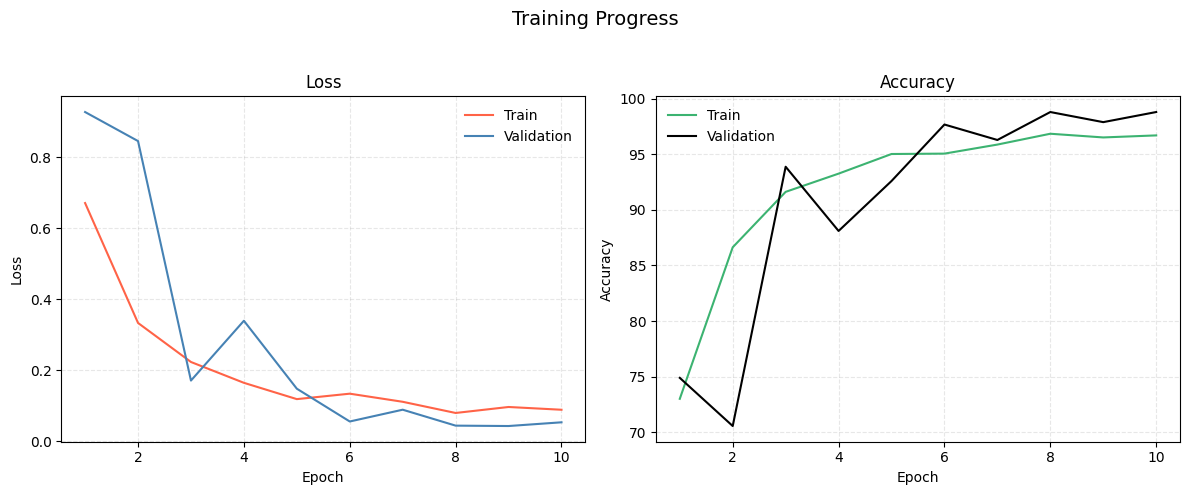

In [15]:
plot_result(result)

In [17]:
results = trainer.evaluate(
    testloader=test_loader,
    model_path="/kaggle/working/medvit_small_exp1_e8_20260215_133009.pt"
)

[========================================] 59/59 | Loss: 0.029 | Accuracy: 98.98%

TEST SET RESULTS
Loss      : 0.0294
Accuracy  : 0.9898
Precision : 0.9901
F1        : 0.9898


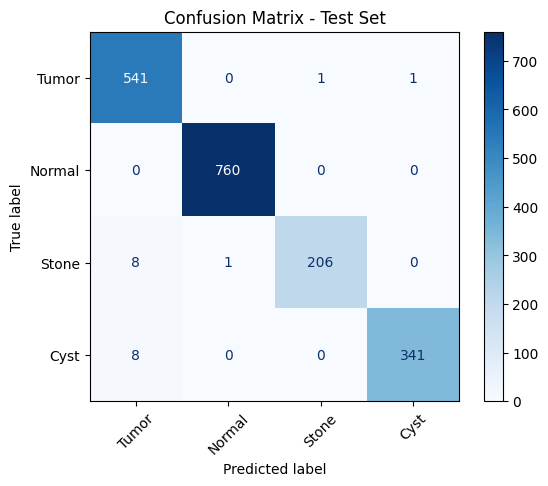

In [18]:
cm = confusion_matrix(results[0], results[1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Tumor', 'Normal', 'Stone', 'Cyst'])
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - Test Set")
plt.show()